# 05.05 Die Hard

Remember we are arguing that *Die Hard* movies are just a
**bunch of middle-aged of blokes hitting each other**.
In order to prove or disprove our statements we collected
cast data about the movies.

Now we again import what we will need and work
on the data using the tools we already know.
We will use the `OrderedDict` to ensure
the correct chronological order of the movies as
we work with them.
This is not needed in modern versions of Python anymore,
where the default dictionary is ordered,
but we keep it in case anyone may be running an old version.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict

We have saved the data to a file.
The file below is data collected at a specific time in $2020$,
this data makes sense for all of the changes below.
More recent data is likely to be more complete.

We also have a good deal of missing data, let's see how much.

In [2]:
df = pd.read_csv('da-die-hard.csv', index_col='webpage_name')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45 entries, Bruce Willis to Sergei Kolesnikov (actor)
Data columns (total 41 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Signature                  0 non-null      float64
 1   Die Hard                   11 non-null     float64
 2   Alma mater                 12 non-null     object 
 3   Instruments                2 non-null      object 
 4   Resting place              1 non-null      object 
 5   Die Hard 2                 12 non-null     float64
 6   Birth name                 1 non-null      object 
 7   Occupation                 42 non-null     object 
 8   Known for                  3 non-null      object 
 9   Citizenship                1 non-null      object 
 10  Education                  6 non-null      object 
 11  Preceded by                2 non-null      object 
 12  Other names                2 non-null      object 
 13  Notable work           

Oh wow!  Most of the columns only have a handful of data, all the remaining rows are nulls.
This is dirty data, therefore we should expect it.
Here we can see that crowd sourced data input (Wikipedia) is often very inconsistent
(e.g. "Parent(s)" vs. "Parents" or "Spouse(s)" vs. "Partner(s)").

What we can do is to select the pieces of data that contain meaningful information
and throw away the rest.  The following keys appear to be usable across most rows.
We also copy the new data frame in order to throw away the old one and save memory.

In [3]:
features = ['Die Hard', 'Die Hard 2', 'Die Hard with a Vengeance',
            'Live Free or Die Hard', 'A Good Day to Die Hard',
            'Alma mater', 'Born', 'Children', 'Nationality',
            'Occupation', 'Occupation(s)', 'Partner(s)', 'Spouse(s)',
            'Years active', 'bday', ]
df = df[features].copy()
df.head()

,Die Hard,Die Hard 2,Die Hard with a Vengeance,Live Free or Die Hard,A Good Day to Die Hard,Alma mater,Born,Children,Nationality,Occupation,Occupation(s),Partner(s),Spouse(s),Years active,bday
webpage_name,,,,,,,,,,,,,,,
Bruce Willis,1.0,1.0,1.0,1.0,1.0,Montclair State University,"Walter Bruce Willis (1955-03-19) March 19, 195...","5, including Rumer",NaN,Actorfilm producer,NaN,NaN,Demi Moore (m. 1987; div. 2000) Emma Heming (m...,1978–present,1955-03-19
Alan Rickman,1.0,NaN,NaN,NaN,NaN,Chelsea College of Art and Design,Alan Sidney Patrick Rickman(1946-02-21)21 Febr...,NaN,NaN,"Actor, director",NaN,NaN,Rima Horton (m. 2012),1974–2016,1946-02-21
Alexander Godunov,1.0,NaN,NaN,NaN,NaN,NaN,Alexander Borisovich Godunov(1949-11-28)Novemb...,NaN,Soviet (1949–1982; def.)[1]United States (1987...,Ballet danceractorballet coach,NaN,Jacqueline Bisset (1981–1988),Lyudmila Vlasova (m. 1971; div. 1982),1958–1995,1949-11-28
Bonnie Bedelia,1.0,1.0,NaN,NaN,NaN,NaN,"Bonnie Bedelia Culkin (1948-03-25) March 25, 1...",2,NaN,Actress,NaN,NaN,Ken Luber (m. 1969; div. 1980) Michael MacRae ...,1957–present,1948-03-25
Reginald VelJohnson,1.0,1.0,NaN,NaN,NaN,NaN,"Reginald Vel Johnson (1952-08-16) August 16, 1...",NaN,NaN,Actor,NaN,NaN,NaN,1979–present,1952-08-16


![John McClane](da-christmas.svg)

<div style="text-align:right;"><sup>da-christmas.svg</sup></div>

<div style="border: 0.3em double teal; border-radius: 0.5em; padding: 0.5em;">
    It has been long debated whether Die Hard is a Christmas movie.
    Yes, the story of several of the Die Hard movies happen during Christmas Eve
    but the movies have been released in the middle of the year.
    Somehow the tradition of showing a Die Hard movie on Christmas Eve
    started across television channels in several countries,
    and that is what consolidated the series as Christmas movies.
</div>

That data frame above is easier to look at.
Now we can go back to the question at hand:
Whether there are really that few women in the cast of Die Hard movies.
We do not have the gender of the cast in our data frame but we have their occupation,
and after looking at a handful of the pages we can see that "Actor" often appears.
Also, there are some references to the occupation in the title of the page,
we can try to use that too.

We try to find the strings "actor" or "Actor" in one of the columns
representing the occupation of the person.
Note that we attempt to match the index as well,
which comes from the page title.

In [ ]:
actor = (df['Occupation'].str.contains('[Aa]ctor')
         | df['Occupation(s)'].str.contains('[Aa]ctor')
         | df.index.str.contains('[Aa]ctor'))
actor = actor.astype(np.int64)
actor

webpage_name
Bruce Willis                 1
Alan Rickman                 1
Alexander Godunov            1
Bonnie Bedelia               0
Reginald VelJohnson          1
Paul Gleason                 1
De'voreaux White             1
William Atherton             1
Clarence Gilyard             1
Hart Bochner                 1
James Shigeta                1
Franco Nero                  1
William Sadler (actor)       1
John Amos                    1
Dennis Franz                 1
Art Evans (actor)            1
Fred Dalton Thompson         0
Tom Bower (actor)            1
Sheila McCarthy              0
Jeremy Irons                 1
Samuel L. Jackson            1
Graham Greene (actor)        1
Colleen Camp                 0
Larry Bryggman               1
Anthony Peck                 1
Nick Wyman                   1
Sam Phillips (musician)      0
Stephen Pearlman             1
Kevin Chamberlin             1
Justin Long                  1
Timothy Olyphant             1
Mary Elizabeth Winstead   

Looks promising, and looks like there are more ones than zeros,
confirming our initial suspicion.
We have not proved anything yet, though.
Add the indicator we have built to our data frame as a new column,
and let's build the "actress" column next.

In [5]:
df['actor'] = actor
df.head()

,Die Hard,Die Hard 2,Die Hard with a Vengeance,Live Free or Die Hard,A Good Day to Die Hard,Alma mater,Born,Children,Nationality,Occupation,Occupation(s),Partner(s),Spouse(s),Years active,bday,actor
webpage_name,,,,,,,,,,,,,,,,
Bruce Willis,1.0,1.0,1.0,1.0,1.0,Montclair State University,"Walter Bruce Willis (1955-03-19) March 19, 195...","5, including Rumer",NaN,Actorfilm producer,NaN,NaN,Demi Moore (m. 1987; div. 2000) Emma Heming (m...,1978–present,1955-03-19,1
Alan Rickman,1.0,NaN,NaN,NaN,NaN,Chelsea College of Art and Design,Alan Sidney Patrick Rickman(1946-02-21)21 Febr...,NaN,NaN,"Actor, director",NaN,NaN,Rima Horton (m. 2012),1974–2016,1946-02-21,1
Alexander Godunov,1.0,NaN,NaN,NaN,NaN,NaN,Alexander Borisovich Godunov(1949-11-28)Novemb...,NaN,Soviet (1949–1982; def.)[1]United States (1987...,Ballet danceractorballet coach,NaN,Jacqueline Bisset (1981–1988),Lyudmila Vlasova (m. 1971; div. 1982),1958–1995,1949-11-28,1
Bonnie Bedelia,1.0,1.0,NaN,NaN,NaN,NaN,"Bonnie Bedelia Culkin (1948-03-25) March 25, 1...",2,NaN,Actress,NaN,NaN,Ken Luber (m. 1969; div. 1980) Michael MacRae ...,1957–present,1948-03-25,0
Reginald VelJohnson,1.0,1.0,NaN,NaN,NaN,NaN,"Reginald Vel Johnson (1952-08-16) August 16, 1...",NaN,NaN,Actor,NaN,NaN,NaN,1979–present,1952-08-16,1


This is dirty data, don't make the mistake of assuming that everything that
is not an actor is an actress!  You might get very surprising (and wrong)
results that way.

Let's repeat the procedure of searching the occupation of each person
for the strings "actress" and "Actress".

In [ ]:
actress = (df['Occupation'].str.contains('[Aa]ctress')
           | df['Occupation(s)'].str.contains('[Aa]ctress')
           | df.index.str.contains('[Aa]ctress'))
actress = actress.astype(np.int64)
df['actress'] = actress
df.head()

,Die Hard,Die Hard 2,Die Hard with a Vengeance,Live Free or Die Hard,A Good Day to Die Hard,Alma mater,Born,Children,Nationality,Occupation,Occupation(s),Partner(s),Spouse(s),Years active,bday,actor,actress
webpage_name,,,,,,,,,,,,,,,,,
Bruce Willis,1.0,1.0,1.0,1.0,1.0,Montclair State University,"Walter Bruce Willis (1955-03-19) March 19, 195...","5, including Rumer",NaN,Actorfilm producer,NaN,NaN,Demi Moore (m. 1987; div. 2000) Emma Heming (m...,1978–present,1955-03-19,1,0
Alan Rickman,1.0,NaN,NaN,NaN,NaN,Chelsea College of Art and Design,Alan Sidney Patrick Rickman(1946-02-21)21 Febr...,NaN,NaN,"Actor, director",NaN,NaN,Rima Horton (m. 2012),1974–2016,1946-02-21,1,0
Alexander Godunov,1.0,NaN,NaN,NaN,NaN,NaN,Alexander Borisovich Godunov(1949-11-28)Novemb...,NaN,Soviet (1949–1982; def.)[1]United States (1987...,Ballet danceractorballet coach,NaN,Jacqueline Bisset (1981–1988),Lyudmila Vlasova (m. 1971; div. 1982),1958–1995,1949-11-28,1,0
Bonnie Bedelia,1.0,1.0,NaN,NaN,NaN,NaN,"Bonnie Bedelia Culkin (1948-03-25) March 25, 1...",2,NaN,Actress,NaN,NaN,Ken Luber (m. 1969; div. 1980) Michael MacRae ...,1957–present,1948-03-25,0,1
Reginald VelJohnson,1.0,1.0,NaN,NaN,NaN,NaN,"Reginald Vel Johnson (1952-08-16) August 16, 1...",NaN,NaN,Actor,NaN,NaN,NaN,1979–present,1952-08-16,1,0


And let's also see who we would consider an actress if we had assumed that
everyone who isn't an actor is an actress.

We also save the index value for these rows
(note: there are no rows where actor == 1 and actress == 1,
in a real situation one would need to check for that too but we leave it for brevity).

In [7]:
no_gender = df[(df['actor'] == 0) & (df['actress'] == 0)]
names = no_gender.index.values
no_gender

,Die Hard,Die Hard 2,Die Hard with a Vengeance,Live Free or Die Hard,A Good Day to Die Hard,Alma mater,Born,Children,Nationality,Occupation,Occupation(s),Partner(s),Spouse(s),Years active,bday,actor,actress
webpage_name,,,,,,,,,,,,,,,,,
Fred Dalton Thompson,NaN,1.0,NaN,NaN,NaN,NaN,"Freddie Dalton Thompson(1942-08-19)August 19, ...",5,NaN,NaN,NaN,NaN,Sarah Knestrick (m. 1959; div. 1985) Jeri Kehn...,NaN,1942-08-19,0,0
Sam Phillips (musician),NaN,NaN,1.0,NaN,NaN,NaN,"(1962-01-28) January 28, 1962 (age 58)Glendal...",NaN,NaN,NaN,"Singer, songwriter",NaN,NaN,1980–present,1962-01-28,0,0
Yorgo Constantine,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0


We could try to guesstimate the gender from the name but that would
probably be using our own bias to make decisions.
Some names can be very tricky to guess the gender of the person.
Instead we should throw these rows away.

In [8]:
df.drop(names, inplace=True)
df.shape

(42, 17)

We have been looking at this data for a while and we can see other columns that
have useful data.

The next piece of information we need to figure out "middle-aged blokes" is age.
Let's see if we have the birth day or the "Born" attribute for everyone.

In [9]:
df[df['Born'].isnull() & df['bday'].isnull()]

,Die Hard,Die Hard 2,Die Hard with a Vengeance,Live Free or Die Hard,A Good Day to Die Hard,Alma mater,Born,Children,Nationality,Occupation,Occupation(s),Partner(s),Spouse(s),Years active,bday,actor,actress
webpage_name,,,,,,,,,,,,,,,,,
Tom Bower (actor),NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Actor,NaN,NaN,NaN,NaN,NaN,1,0


Just one person has neither.
And the only reason he is part of our dataset is because of his page title,
i.e. we pretty much have no data about him.
We can go forward without this row.

In [10]:
df.drop('Tom Bower (actor)', inplace=True)
df.shape

(41, 17)

Now let's see if we will need to use the "Born" attribute to build the birth date
of some of the people in our set.  i.e. whether everyone has the "bday" column.

In [11]:
no_bday = df[df['bday'].isnull()]
no_bday

,Die Hard,Die Hard 2,Die Hard with a Vengeance,Live Free or Die Hard,A Good Day to Die Hard,Alma mater,Born,Children,Nationality,Occupation,Occupation(s),Partner(s),Spouse(s),Years active,bday,actor,actress
webpage_name,,,,,,,,,,,,,,,,,
Christina Chang,NaN,NaN,NaN,1.0,NaN,University of Washington,"Taipei, Taiwan",1,NaN,Actress,NaN,NaN,Soam Lall (m. 2010),1998–present,NaN,0,1


Okay, one row has no birth date.
But moreover, the "Born" attribute has no date either.
This is very common with plain dirty data,
one cannot tell what the person inputting the data assumes the data should mean.

We could just kill off this row too but let's try a trick:
let's assume that she started her career when she was $20$ years old,
and guess her age accordingly.
We know the year when she started the career based on the "Years Active" attribute.

In [ ]:
byear = no_bday['Years active'].str.extract('(\d+)', expand=False).astype(np.int64) - 20
byear

webpage_name
Christina Chang    1978
Name: Years active, dtype: int64

We do not know the actual birth day, let's just say $1st$ of January.
Which is a low estimate.
The $20$ years old as the start of the career was actually a high estimate,
most actors/actresses start before that.
One estimate up and one down should be a good enough shot.

And that's probably enough playing around with this data.
Let's have a look again at how many nulls we have in this new,
cleaned up, data frame.

In [ ]:
bday = byear.astype(str) + '-01-01'
df.loc[df['bday'].isnull(), 'bday'] = bday
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41 entries, Bruce Willis to Sergei Kolesnikov (actor)
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Die Hard                   11 non-null     float64
 1   Die Hard 2                 10 non-null     float64
 2   Die Hard with a Vengeance  10 non-null     float64
 3   Live Free or Die Hard      12 non-null     float64
 4   A Good Day to Die Hard     6 non-null      float64
 5   Alma mater                 12 non-null     object 
 6   Born                       41 non-null     object 
 7   Children                   17 non-null     object 
 8   Nationality                11 non-null     object 
 9   Occupation                 41 non-null     object 
 10  Occupation(s)              0 non-null      object 
 11  Partner(s)                 2 non-null      object 
 12  Spouse(s)                  23 non-null     object 
 13  Years active           

Several columns are full of values, notably the columns we have created.
Apart from that we know that that columns with the movie titles contain
`NaN`s where the person did not participate in the movie.
Instead of a `NaN` we should place a zero there.

Let's therefore fill the nulls and select only the columns that are needed
to answer our initial question.
We only need the gender indicators and the birthdays.

In [14]:
features = ['Die Hard', 'Die Hard 2', 'Die Hard with a Vengeance',
            'Live Free or Die Hard', 'A Good Day to Die Hard',
            'actor', 'actress', 'bday', ]
df = df[features].copy()
df = df.fillna(0)
df['bday'] = pd.to_datetime(df['bday'])
df.head()

,Die Hard,Die Hard 2,Die Hard with a Vengeance,Live Free or Die Hard,A Good Day to Die Hard,actor,actress,bday
webpage_name,,,,,,,,
Bruce Willis,1.0,1.0,1.0,1.0,1.0,1,0,1955-03-19
Alan Rickman,1.0,0.0,0.0,0.0,0.0,1,0,1946-02-21
Alexander Godunov,1.0,0.0,0.0,0.0,0.0,1,0,1949-11-28
Bonnie Bedelia,1.0,1.0,0.0,0.0,0.0,0,1,1948-03-25
Reginald VelJohnson,1.0,1.0,0.0,0.0,0.0,1,0,1952-08-16


Finally some *clean* data.
Calculating the age now is a simple task: parse the dates and subtract.

In [15]:
df['age'] = (pd.to_datetime('2020-01-01') - df['bday']).dt.days // 365.25
df

,Die Hard,Die Hard 2,Die Hard with a Vengeance,Live Free or Die Hard,A Good Day to Die Hard,actor,actress,bday,age
webpage_name,,,,,,,,,
Bruce Willis,1.0,1.0,1.0,1.0,1.0,1,0,1955-03-19,64.0
Alan Rickman,1.0,0.0,0.0,0.0,0.0,1,0,1946-02-21,73.0
Alexander Godunov,1.0,0.0,0.0,0.0,0.0,1,0,1949-11-28,70.0
Bonnie Bedelia,1.0,1.0,0.0,0.0,0.0,0,1,1948-03-25,71.0
Reginald VelJohnson,1.0,1.0,0.0,0.0,0.0,1,0,1952-08-16,67.0
Paul Gleason,1.0,0.0,0.0,0.0,0.0,1,0,1939-05-04,80.0
De'voreaux White,1.0,0.0,0.0,0.0,0.0,1,0,1965-08-06,54.0
William Atherton,1.0,1.0,0.0,0.0,0.0,1,0,1947-07-30,72.0
Clarence Gilyard,1.0,0.0,0.0,0.0,0.0,1,0,1955-12-24,64.0


The age of the cast as of January the $1st$, $2020$
is not a good indicator of what we see in the movies.
A movies is a snap of time where the actors remain a specific age.
We will need an extra piece of data: the release date of each movie.

The release date is not an exact description of when the movie was filmed
but it is a good enough estimate.
Now, when we compare the age of the cast of a movie we subtract
the years since the release of the movie.

In [16]:
release = OrderedDict(
    {'Die Hard': '1988-07-15',
     'Die Hard 2': '1990-07-04',
     'Die Hard with a Vengeance': '1995-05-19',
     'Live Free or Die Hard': '2007-06-27',
     'A Good Day to Die Hard': '2013-02-14',
    })
for k, v in release.items():
    release[k] = (pd.to_datetime('2020-01-01') - pd.to_datetime(v)).days // 365.25
release

OrderedDict([('Die Hard', 31.0),
             ('Die Hard 2', 29.0),
             ('Die Hard with a Vengeance', 24.0),
             ('Live Free or Die Hard', 12.0),
             ('A Good Day to Die Hard', 6.0)])

We will want to do some statistics over the cast of each movie.
It is time to build another data structure:
We keep the full data frame as the total of all movies then divide
(make views) of the data frame based on the columns of each movie.
The cast of the movies may overlap, therefore the same actor/actress
can be in several of these views of the data frame.

In [17]:
dh = OrderedDict()
movies = ['Die Hard', 'Die Hard 2',
          'Die Hard with a Vengeance', 'Live Free or Die Hard', 'A Good Day to Die Hard']
for m in movies:
    dh[m] = df[df[m] == 1]
dh.keys()

odict_keys(['Die Hard', 'Die Hard 2', 'Die Hard with a Vengeance', 'Live Free or Die Hard', 'A Good Day to Die Hard'])

Plotting time!
We have the data in the format we'd like to answer the question that brought us here:
Are there many more male cast in Die Hard movies than female?

For each data frame view we plot several bars:
the fatter bars represent the gender ratio (total, actors, actresses),
and the smaller bars are the mean age of each group.
Most of this code is graph prettifying.

We use the `bar` plot from `matplotlib` directly.
The routine takes the position of the bars as the first argument
and the height of the bars as the second argument.
In a loop we plot the large bars against the left axis
of cast counts,
and we plot the thin bars against the right axis of age.
We do it for each of the movies.
After that we add extra thick bars against the left axis
containing the total cast counts across all movies.

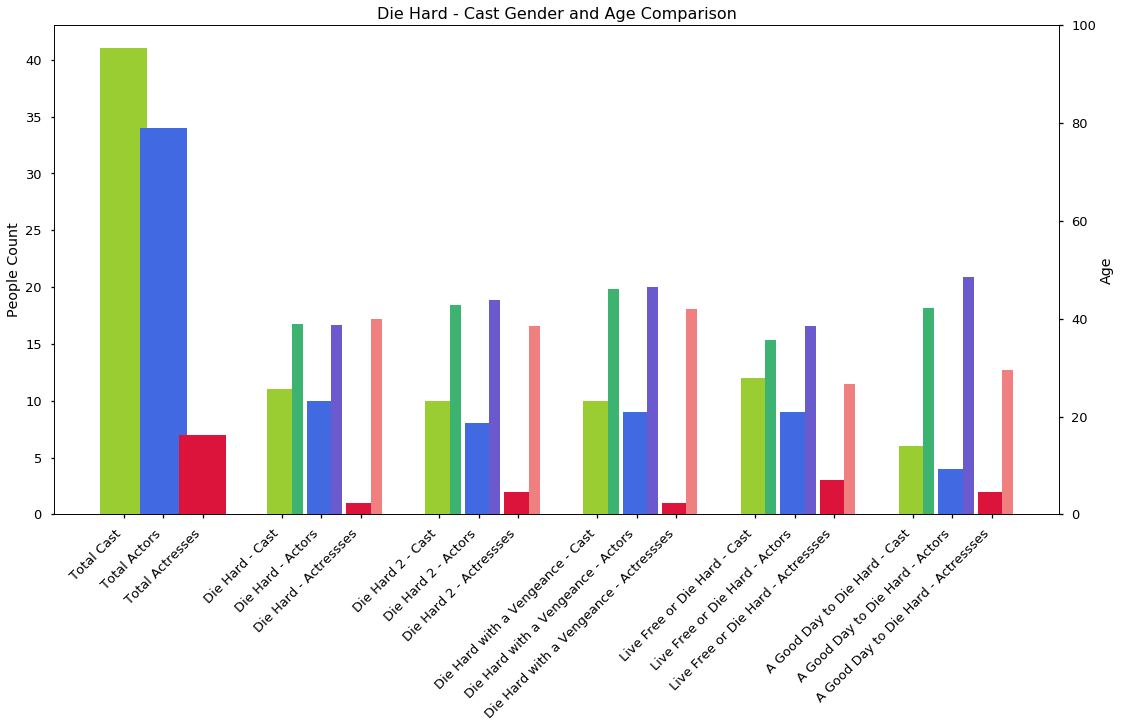

In [18]:
fig, axl = plt.subplots(figsize=(18, 9))
axr = axl.twinx()
l_height = []
r_height = []
labels = []
l_base = np.array([1, 1.25, 1.50])
r_base = np.array([1.10, 1.35, 1.60])
l_positions = np.array([])
r_positions = np.array([])
next_position = 0
for m, data in dh.items():
    actor = data[data['actor'] == 1]
    actress = data[data['actress'] == 1]
    l_positions = np.append(l_positions, l_base + next_position)
    r_positions = np.append(r_positions, r_base + next_position)
    l_height += [len(data), data.actor.sum(), data.actress.sum()]
    s = release[m]
    r_height += [data.age.mean() - s, actor.age.mean() - s, actress.age.mean() - s]
    labels += [m + ' - Cast', m + ' - Actors', m + ' - Actressses']
    next_position += 1
    
c = ['yellowgreen', 'royalblue', 'crimson']
axl.bar(l_base - 1, [len(df), df.actor.sum(), df.actress.sum()], width=0.3, color=c)
axl.bar(l_positions, l_height, width=0.18, color=c)
axl.set_xticks(np.append(l_base - 1, l_positions))
axl.set_xticklabels(['Total Cast', 'Total Actors', 'Total Actresses'] + labels)
axl.set_xticklabels(axl.get_xticklabels(), rotation=45, ha='right')
axl.set_title('Die Hard - Cast Gender and Age Comparison', fontsize=16)
axl.set_ylabel('People Count')
c = ['mediumseagreen', 'slateblue', 'lightcoral']
axr.bar(r_positions, r_height, width=0.07, color=c)
axr.set_ylim(0, 100)
axr.set_ylabel('Age');

## Conclusions

We can answer our question with a **yes**.
The male cast overwhelms the female cast in the Die Hard movies,
and the ages are past the $40$s for actors.
In the last movies the ratio has been getting more even but it is still far off.

The male cast keeps with the movies, e.g. Bruce Willis plays in all of them
but the female cast changes.
This likely explains the male mean age going up over time.
Another option is that newer movies casted more younger actresses.
Possibly a combination of both effects.